# This Notebook Explores Additional Approaches to Tuning SARIMA

- The large possibilities and computational demands of naively brut force tuning SARIMA by guessing have not been effective, to the point where it has been difficult to modularize the approach we'd planned on to automate testing all 40 ANCs

- A large portion of the problem is attempting to fit models at reasonably high frequencies while maintaining the clear daily seasonality component in our data. This results in exploding gradients due to the larger s (also known as m) components

- We will first try some "auto ARIMA" style tools to estimate best params

- We will then (time permitting) attempt to find an implementation of "Functional PCA" (FPCA) as described in PAPER REFERENCE

In [1]:
import cabi.etl.load as l
import pandas as pd
import numpy as np



## Import the Data

In [2]:
cols = ['1A', '2B', '3C', '4D']

In [3]:
df = pd.concat([l.load_counts(col) for col in cols], axis=1)

In [4]:
df

,1A,2B,3C,4D
time,,,,
2020-04-01 00:25:48,0,0,0,0
2020-04-01 00:27:59,0,0,0,0
2020-04-01 01:36:09,0,0,0,0
2020-04-01 01:39:17,0,0,0,0
2020-04-01 01:47:36,-1,0,0,0
...,...,...,...,...
2020-08-01 01:52:27,0,0,0,0
2020-08-01 01:56:45,0,0,0,0
2020-08-01 02:50:22,0,0,0,0


In [13]:
from pmdarima.arima import ADFTest
from pmdarima.arima.utils import nsdiffs
adf_test = ADFTest(alpha = 0.05)


## Prepare Data for Forecasting

In [7]:
from scipy.stats import mode

In [8]:
# Target is the cumulative change over six hour period
df_six_hours = df.rolling('6H').sum()


In [10]:
# regularize target frequency
hourly = df_six_hours.resample('1H').apply(lambda x: mode(x)[0] if mode(x)[0].size > 0 else 0)

hourly


,1A,2B,3C,4D
time,,,,
2020-04-01 00:00:00,0.0,0.0,0.0,0.0
2020-04-01 01:00:00,-1.0,0.0,0.0,0.0
2020-04-01 02:00:00,-2.0,0.0,0.0,0.0
2020-04-01 03:00:00,-3.0,0.0,0.0,0.0
2020-04-01 04:00:00,-3.0,0.0,0.0,0.0
...,...,...,...,...
2020-08-01 04:00:00,0.0,0.0,0.0,0.0
2020-08-01 05:00:00,0.0,0.0,0.0,0.0
2020-08-01 06:00:00,0.0,0.0,0.0,0.0


In [14]:
# Test Stationarity of the series
adf_tests_dict = {col:adf_test.should_diff(hourly[col]) for col in hourly.columns}
adf_tests_dict

{'1A': (0.01, False),
 '2B': (0.01, False),
 '3C': (0.01, False),
 '4D': (0.01, False)}

## Above result implies stationarity (should not difference i.e. d=0)


In [15]:
%%time

# Test Seasonal Differencing Term
## SOURCE MATERIAL AT https://alkaline-ml.com/pmdarima/tips_and_tricks.html

# Testing with a 24 hour (daily) seasonal component m
# also known as 's' in the SARIMAX implementations
# D may be quite large, but we'll start with 6 to test runtime
# and %%time the cell, will try both Canova-Hansen
# and default ocsb tests
D_dict = {col:nsdiffs(hourly[col],
                     m=24,
                     max_D=6,
                     test='ch')
          for col in hourly.columns}


CPU times: user 301 ms, sys: 7.53 ms, total: 308 ms
Wall time: 85.9 ms


In [17]:
D_dict

{'1A': 1, '2B': 1, '3C': 1, '4D': 0}

In [25]:
%%time

# That Ran Really Fast!
# Let's try larger max D, and then ocsb tests
D_dict = {col:nsdiffs(hourly[col],
                     m=24,
                     max_D=24,
                     test='ch')
          for col in hourly.columns}

D_dict


CPU times: user 320 ms, sys: 5.49 ms, total: 326 ms
Wall time: 86.9 ms


{'1A': 1, '2B': 1, '3C': 1, '4D': 0}

In [24]:
%%time

#Ocsb method

D_dict_ocsb = {col:nsdiffs(hourly[col],
                     m=24,
                     max_D=12,
                     test='ocsb')
          for col in hourly.columns}

D_dict_ocsb

CPU times: user 164 ms, sys: 3.63 ms, total: 167 ms
Wall time: 43.6 ms


{'1A': 0, '2B': 0, '3C': 0, '4D': 0}

## OCSB Test indicates no differencing, but Canova-Hansen Disagrees

- We may want to try both, but let's try D=1 for now as the PACF plots we've looked at previously indicate some seasonal differencing may be appropriate

- Let's try a first go at auto_arima, we won't cross-validate at first just to get a sense of the time we're looking at to fit

In [35]:
import pmdarima as pm

# We'll Model 1 column first
data = hourly['1A']

# Split - We'll do a one week prediction with one month's data
train = data[(hourly.index > '2020-06-07 04:00:00') & (hourly.index <= '2020-07-07 04:00:00')]
test = data[(hourly.index > '2020-07-07 04:00:00') & (hourly.index <= '2020-07-14 04:00:00')]

In [37]:
%%time

# Leaving the defaults to benchmark time,
# we'll look at effect of passing some params shortly
model = pm.auto_arima(train, error_action='ignore', seasonal=True, m=24)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization fa

CPU times: user 10min 8s, sys: 2.97 s, total: 10min 11s
Wall time: 2min 53s


In [38]:
model

ARIMA(maxiter=50, method='lbfgs', order=(5, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(2, 0, 0, 24),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

## Under 3 Minutes? That Was Insanely Faster than the Several Hours We've Been Looking at with Brute Force GridSearch from Scratch

- Let's see how the model performed and then give this another go using some of our intuition from previous (maybe not fruitless?) attempts

Text(0.5, 1.0, 'Test samples vs. forecasts (m=24)')

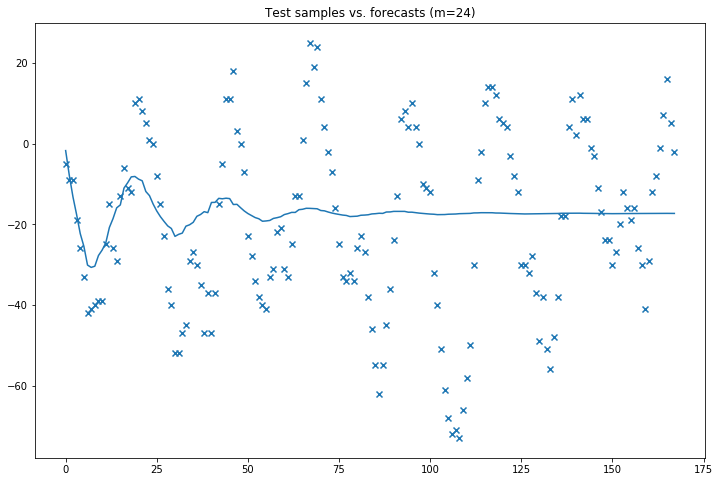

In [40]:
# Cribbing the perfectly nice implementation from the pmdarima
# docs cited above

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(test.shape[0])

# Plot m=1
ax.scatter(x, test, marker='x')
ax.plot(x, model.predict(n_periods=test.shape[0]))
ax.set_title('Test samples vs. forecasts (m=24)')



In [41]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  720
Model:             SARIMAX(5, 0, 0)x(2, 0, 0, 24)   Log Likelihood               -2415.312
Date:                            Thu, 03 Sep 2020   AIC                           4848.624
Time:                                    00:02:33   BIC                           4889.837
Sample:                                         0   HQIC                          4864.535
                                            - 720                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -3.0878      0.445     -6.933      0.000      -3.961      -2.215
ar.L1          1.0069      0.037   

## Interpretation:

- Not Horrible for being so fast, in fact, really good for being so fast. However, it's awfully smooth relatively quickly, (could be supplemented with walk-forward?).

- Jarque-Bera and Ljung-Box already look way better at higher values of p that we have not been testingm but AIC is not as good as we've seen with more complexity at lower values with brute force

- Let's try a little bit of tinkering with the auto-arima params

In [42]:
# Intuition Says p is much higher, let's start with the
# p we ended with, since that was a default max, and
# there may well be better options higher up, likewise,
# numerous brute force attempts have shown that higher P
# is in general better than lower, let's start that where
# we ended as well, last, D=1 seems like a reasonable bet
# additionally, we'll likely hit a bunch of warnings,
# let's suppress these
model2 = pm.auto_arima(train, start_p=5,
                       start_P=2,
                       D=1,
                       suppress_warnings=True,
                       error_action='ignore',
                       seasonal=True, m=24)


In [43]:
model2

ARIMA(maxiter=50, method='lbfgs', order=(5, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(2, 1, 0, 24),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

Text(0.5, 1.0, 'Test samples vs. forecasts (m=24)')

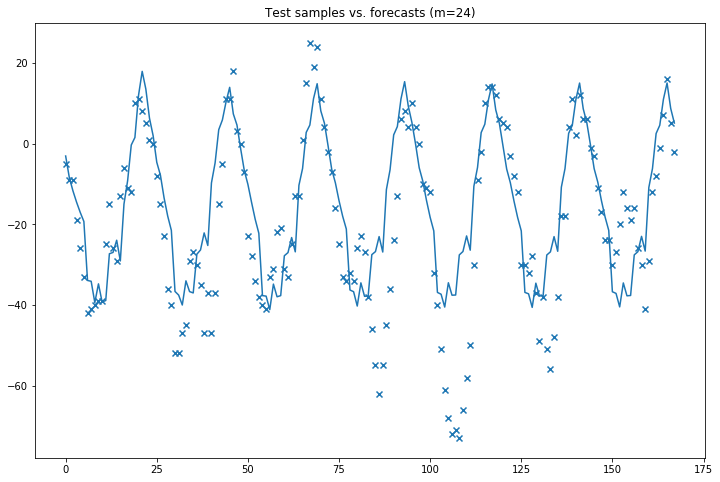

In [46]:
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(test.shape[0])

# Plot m=1
ax.scatter(x, test, marker='x')
ax.plot(x, model2.predict(n_periods=test.shape[0]))
ax.set_title('Test samples vs. forecasts (m=24)')

In [45]:
print(model2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  720
Model:             SARIMAX(5, 0, 0)x(2, 1, 0, 24)   Log Likelihood               -2406.598
Date:                            Thu, 03 Sep 2020   AIC                           4829.195
Time:                                    00:14:14   BIC                           4865.558
Sample:                                         0   HQIC                          4843.255
                                            - 720                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9188      0.039     23.595      0.000       0.843       0.995
ar.L2          0.0427      0.057   

## Runtime for the first model made us a bit too optimistic about the runtimes, should definitely have timed that one as well

- Nonetheless, didn't take too long, and we've improved both Jarque-Bera and Ljung-Box slightly.

- Most notable things about both of these results is that most of the AR terms are not significant at our default alpha of .05

- The Second Model looks far better than the first when it comes to the predictions plot. The recovery of model performance towards the end of the one week period also begs the question of whether or not the days it did most poorly on were perhaps weekends? Let's investigate that below. If so, this would back our original intuition that it would be good to somehow include an additional "weekly" seasonality. One plot index where we appear to miss is around 100, let's investigate where that occurs in the test index before proceeding

In [53]:
test.index[100].day_name()


'Saturday'

## This Model is Definitely Worth Saving
- Let's Look at Adding an Additional Weekly Seasonal Component after we finish playing with auto_arima (even by a one-hot is_weekend type deal)

Model Params:
SARIMAX(5, 0, 0)x(2, 1, 0, 24)

- Since we are doing reasonably well according to the predictions plot vs. test data, it's also worth starting to evaluate some more interpretable metrics moving forward.

- One of the motivating papers behind the approach in this book has an excellent description of model metrics application to this type of problem, which we'll quote here:

From https://scholarsmine.mst.edu/cgi/viewcontent.cgi?article=8666&context=masters_theses
Extending time series forecasting methods using functional principal components analysis

"""5.4. GENERATION OF FORECASTS AND PREDICTION INTERVALS
These forecasts are only useful if they manage to describe the next day’s events.
There are many ways to measure the quality of a forecast. The methods that will be used
here are mean percent error (MPE), mean absolute percent error (MAPE) and root mean
squared error (RMSE). MPE will demonstrate how the model overpredicts or underpredicts
traffic over time while MAPE and RMSE will show how far apart the models are from
reality.
The mean and median values of MPE and MAPE are useful for determining if the
models are consistently overpredicting or underpredicting traffic volume. MPE and MAPE
do poorly when the observed data is zero or near zero. Outliers are best found using the
RMSE measure. Since the RMSE is computed without using division, zero/small observed
values do not distort the distribution of the population as much."""

Following this logic, let's bring in the necessary imports, we'll simplify a bit and just use MAPE instead of both MPE and MAPE.

In [64]:
# Imports
from sklearn.metrics import mean_squared_error



In [65]:
# Wrapping these a bit for ease of use

def RMSE(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def MAPE(y_true, y_pred):
     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [66]:
# Slight Issue in that all of these are close to zero, may want to work out
# a workaround on that.
mod2_preds = model2.predict(n_periods=test.shape[0])
print(MAPE(test, mod2_preds), RMSE(test, mod2_preds))

inf 14.068660022040872


### Okay, this looks like a decent fit, but let's test this a bit more and see how well we can do. We'll use a similar approach to our last iteration in hopes of packaging this up if it works.

Starting from SARIMAX(5, 0, 0)x(2, 1, 0, 24):

In [68]:
%%time
# Intuition Says p is much higher, but since the model was stable at the last
# params, let's first try higher P since we observed it did better on brute
# force approach at p>= 3, and leave the other components in place this
# iteration
model3 = pm.auto_arima(train, start_p=5,
                       start_P=3,
                       start_Q=2,
                       D=1,
                       suppress_warnings=True,
                       error_action='ignore',
                       seasonal=True, m=24)

ValueError: max_P must be >= start_P

In [69]:
%%time
# Interesting, the auto_arima does not automatically update max vals.
# Let's do that first, before manually increasing starts:

model3 = pm.auto_arima(train, start_p=5,
                       max_p=10,
                       start_P=2,
                       max_P=5,
                       start_Q=2,
                       D=1,
                       suppress_warnings=True,
                       error_action='ignore',
                       seasonal=True, m=24)


CPU times: user 9h 56min 35s, sys: 2min 20s, total: 9h 58min 55s
Wall time: 2h 30min 41s


In [70]:
print(model3.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  720
Model:             SARIMAX(9, 0, 2)x(5, 1, [], 24)   Log Likelihood               -2293.236
Date:                             Thu, 03 Sep 2020   AIC                           4620.472
Time:                                     03:18:45   BIC                           4697.743
Sample:                                          0   HQIC                          4650.350
                                             - 720                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8990      0.054     35.008      0.000       1.793       2.005
ar.L2         -1.6327      

Text(0.5, 1.0, 'Test samples vs. forecasts (m=24)')

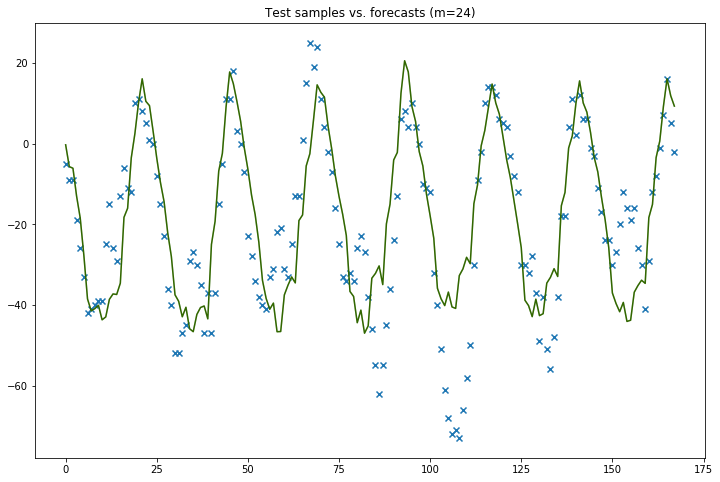

In [74]:
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(test.shape[0])

# Plot m=1
ax.scatter(x, test, marker='x')
ax.plot(x, model3.predict(n_periods=test.shape[0]), color='green')
ax.plot(x, model3.predict(n_periods=test.shape[0]), color='red', alpha=0.2)
ax.set_title('Test samples vs. forecasts (m=24)')

## An Aside on our Business Case While The Above Code Runs:

From a Next Day- Next Couple Days Perspective, this is an excellent result.

From a weekly perspective (and we'd really like to be at bi-weekly, to solve our employee scheduling use case), we have the following issue:


The model predictions relative to where we started are already better enough for this approach to be worth while. The real question now is the stability of the model. In other words, if it takes forever and a day to fit each model object once, that's okay even for 40 models as long as they perform. However, if it turns out that this overfits to the point where the order/seasonal order parameters are unstable, that's not so good. If we only need to feed new data to an existing expensive fit, not a problem, but if we need to refit constantly, these models need to be able to run at no more than say: fifteen minutes per ANC *in parallel* for this to be an effective prediction method from a business perspective. Otherwise, we might as well get some weather data and engineer hourly/day_of_week features and run xgboost.

Though stability is the real question, in prototyping, we'd also like to iterate a bit faster, so as a note, one should probably not increase max anything by more than a couple ticks per iteration. The larger the values, the longer the model will need to fit for each iteration, so even without increasing max_iter, we've again expanded this problem quite a bit by increasing max by so much in one go. Don't do this going forward.

In [75]:
mod3_preds = model3.predict(n_periods=test.shape[0])
print(MAPE(test, mod3_preds), RMSE(test, mod3_preds))

inf 13.293591675448216


## Evaluation:

- Seriously, One Step At a Time, We've Gone From Like Five Minutes Run Time to back to the bad old bruteforce days..

- Notable improvement in Ljung-Box, Jarque-Bera, skew and kurtosis look quite good, and more of our coefficients are significant at alpha of 0.05. RMSE improved, though improvement is slowing. We are definitely starting to see limited returns for the additional effort, given the time it took to fit, but before generalizing this approach to all 40 ANCs, let's see how well we can do on this one, and check for similar results on one or two different areas.

In [ ]:
%%time
# Interesting, the auto_arima does not automatically update max vals.
# Let's do that first, before manually increasing starts:

model3 = pm.auto_arima(train, start_p=5,
                       max_p=10,
                       start_P=2,
                       max_P=5,
                       start_Q=2,
                       D=1,
                       suppress_warnings=True,
                       error_action='ignore',
                       seasonal=True, m=24)

## Additional Modular Improvements to Test

- Pipeline will help with automating this process
- Fourier Featurizer may be a better way of representing the weekly seasonality observed than a simple one-hot for is weekend or multiple one-hot for day of week
- Cross-validated predictions in addition to cross-validated fits
- Functional PCA may have better fits and/or speed this process

In [ ]:


Pipeline(steps=[('fourier', FourierFeaturizer(k=4, m=12)),
                ('arima',
                 AutoARIMA(error_action='ignore', seasonal=False,
                           suppress_warnings=True, trace=1))])

## IS THIS FASTER THAN PLAIN SARIMA???

# Let's create a pipeline with multiple stages... the Wineind dataset is
# seasonal, so we'll include a FourierFeaturizer so we can fit it without
# seasonality
pipe = pipeline.Pipeline([
    ("fourier", ppc.FourierFeaturizer(m=12, k=4)),
    ("arima", arima.AutoARIMA(stepwise=True, trace=1, error_action="ignore",
                              seasonal=False,  # because we use Fourier
                              suppress_warnings=True))

In [ ]:
## FROM the pmdarima docs again, sample conf_int:
## https://alkaline-ml.com/pmdarima/auto_examples/example_pipeline.html#sphx-glr-auto-examples-example-pipeline-py


# We can compute predictions the same way we would on a normal ARIMA object:
preds, conf_int = pipe.predict(n_periods=10, return_conf_int=True)
print("\nForecasts:")
print(preds)



In [71]:
## This looks like a really good idea, as long as it doesn't run forever

# Cross-validation predictions
# In addition to computing cross-validation scores, you can use cross-validation
# to produce predictions. Unlike traditional cross-validation, where folds 
# are independent of one another, time-series folds may overlap (particularly
# in a sliding window). To account for this, folds that forecast the same time
# step average their forecasts using either a “mean” or “median” (tunable).

## Functional PCA

Thought process informed by the thesis: "Extending time series forecasting methods using functional
principal components analysis" by Isaac Michael Wagner-Muns, retrieved from https://scholarsmine.mst.edu/cgi/viewcontent.cgi?article=8666&context=masters_theses

Python Implementation example found at https://towardsdatascience.com/beyond-classic-pca-functional-principal-components-analysis-fpca-applied-to-time-series-with-python-914c058f47a0 using the fdasrsf package (https://fdasrsf-python.readthedocs.io/en/latest/index.html)

In [ ]:
from fdasrsf import fPCA, time_warping, fdawarp, fdahpca



# Rename columns to simplify syntax
df = df.rename(columns={"Code INSEE département": "Region", "TMax (°C)": "Temp"})

# Select 2019 records only
df = df[(df["Date"]>="2019-01-01") & (df["Date"]<="2019-12-31")]

# Pivot table to get "Date" as index and regions as columns 
df = df.pivot(index='Date', columns='Region', values='Temp')

# Select a set of regions across France
df = df[["06","25","59","62","83","85","75"]]

display(df)

# Convert the Pandas dataframe to a Numpy array with time-series only
f = df.to_numpy().astype(float)

# Create a float vector between 0 and 1 for time index
time = np.linspace(0,1,len(f))